# 0. IMPORTANT--Specify classifier to be trained and dataset

In [1]:
model_name = 'dt'  # options include: {'Decision Tree': 'dt', 'Gaussian Naive Bayes':'gnb',\
                           #                  'Logistic Regression': 'lgr', \
                           #                  'Support Vector Machine Linear': 'svm_linear', \ 
                           #                  'Gradient_Boosted_Trees': 'gbt'} 
data_file = '/home/mackenzie/git_repositories/delayedimpact/data/simData_oom100.csv'  # ...oom10, ...oom50, ...oom100

# 1. Imports and Set Up

In [2]:
from impt_functions import *
import csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, EqualizedOdds, \
    TruePositiveRateParity, FalsePositiveRateParity, ErrorRateParity, BoundedGroupLoss
from fairlearn.metrics import *
from raiwidgets import FairnessDashboard
%matplotlib inline

In [3]:
# Dict used for saving overall results to a csv later
# Example: overall = {'Unmitigated':[], 'EG DP': [], 'EG EO': [],
#                   'EG EOO': [], 'EG FPRP': [], 'EG ERP': [],
#                   'GS DP': [], 'GS EO': [],
#                   'GS EOO': [], 'GS FPRP': [], 'GS ERP': []}
# Example: black_results = {'Unmitigated Black': [], 
#                          'EG DP Black': [], ..., 'GS ERP Black': []}

# Instantiate lists for holding results
unmitigated, unmitigated_black, unmitigated_white = [], [], []

eg_dp, eg_dp_black, eg_dp_white = [], [], []
eg_eo, eg_eo_black, eg_eo_white = [], [], []
eg_eoo, eg_eoo_black, eg_eoo_white = [], [], []
eg_fprp, eg_fprp_black, eg_fprp_white = [], [], []
eg_erp, eg_erp_black, eg_erp_white = [], [], []

gs_dp, gs_dp_black, gs_dp_white = [], [], []
gs_eo, gs_eo_black, gs_eo_white = [], [], []
gs_eoo, gs_eoo_black, gs_eoo_white = [], [], []
gs_fprp, gs_fprp_black, gs_fprp_white = [], [], []
gs_erp, gs_erp_black, gs_erp_white = [], [], []

# 2. Prepare data

In [4]:
data = get_data(data_file)

       score  repay_probability  race  repay_indices
0        601              75.21     1              1
1        693              95.15     1              1
2        791              98.62     1              1
3        637              86.69     1              1
4        775              98.45     1              1
...      ...                ...   ...            ...
99995    797              98.73     1              1
99996    562              58.57     1              1
99997    687              94.60     1              1
99998    589              70.61     1              1
99999    555              52.97     1              0

[100000 rows x 4 columns]


In [5]:
print(type(data))
print(data)

<class 'pandas.core.frame.DataFrame'>
       score  repay_probability  race  repay_indices
0        601              75.21     1              1
1        693              95.15     1              1
2        791              98.62     1              1
3        637              86.69     1              1
4        775              98.45     1              1
...      ...                ...   ...            ...
99995    797              98.73     1              1
99996    562              58.57     1              1
99997    687              94.60     1              1
99998    589              70.61     1              1
99999    555              52.97     1              0

[100000 rows x 4 columns]


In [6]:
X_train, X_test, y_train, y_test, race_train, race_test, sample_weight_train, sample_weight_test = prep_data(data=data, test_size=0.3, weight_index=1)

Here are the x values:  [[601   1]
 [693   1]
 [791   1]
 ...
 [687   1]
 [589   1]
 [555   1]] 

Here are the y values:  [1 1 1 ... 1 1 0]
Sample weights are all equal.


(array([   8.,  182.,  773.,  220.,  325.,  703.,  754.,  702., 1014.,
         766.,  828.,  523.,  525., 1216., 1006., 1305.,  695.,  923.,
        1201., 1583., 1210., 1135., 1442., 1621., 1806., 1721., 2430.,
        1875., 2498., 2043., 2292., 2929., 2495., 2803., 2509., 2790.,
        3038., 2690., 3148., 3067., 4063., 3865., 3995., 3617., 2884.,
        3223., 1921.,  849., 2454.,  335.]),
 array([300., 311., 322., 333., 344., 355., 366., 377., 388., 399., 410.,
        421., 432., 443., 454., 465., 476., 487., 498., 509., 520., 531.,
        542., 553., 564., 575., 586., 597., 608., 619., 630., 641., 652.,
        663., 674., 685., 696., 707., 718., 729., 740., 751., 762., 773.,
        784., 795., 806., 817., 828., 839., 850.]),
 <BarContainer object of 50 artists>)

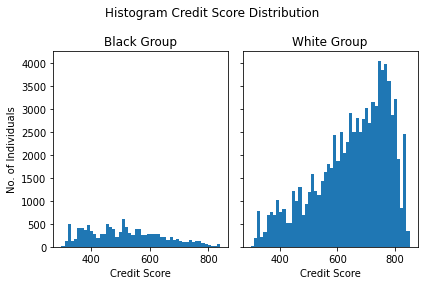

In [8]:
# make histogram of credit scores by race
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Histogram Credit Score Distribution')
plt.xlabel("Credit Score")
#plt.ylabel("No. of Individuals")

black_credit_dist = data['score'].loc[data['race']==0]
white_credit_dist = data['score'].loc[data['race']==1]

n_bins = 50
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(black_credit_dist, bins=n_bins)
axs[0].set_title('Black Group')
axs[0].set_xlabel('Credit Score')
axs[0].set_ylabel('No. of Individuals')
axs[1].set_title('White Group')
axs[1].hist(white_credit_dist, bins=n_bins)

Text(0.5, 1.0, 'White Group')

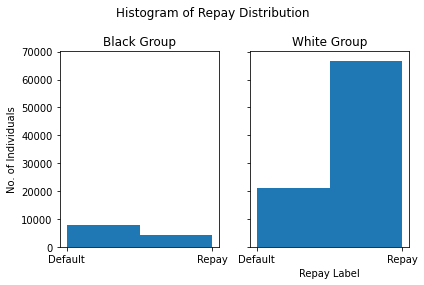

In [10]:
# make histogram of repay or not by racefig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Histogram of Repay Distribution')
plt.xlabel("Repay Label")

black_label_dist = data['repay_indices'].loc[data['race']==0]
white_label_dist = data['repay_indices'].loc[data['race']==1]

#print(black_label_dist)
#print(white_label_dist)

# maybe see if the label is an int or a float

# default: 0, repay: 1

n_bins = 2
# We can set the number of bins with the *bins* keyword argument.
#start, end = ax.get_xlim()
stepsize=1
axs[0].xaxis.set_ticks(np.arange(0, 2, stepsize))
axs[0].set_xticklabels(['Default','Repay'])
axs[0].hist(black_label_dist, bins=n_bins)
axs[0].set_title('Black Group')
axs[0].set_ylabel('No. of Individuals')

axs[1].xaxis.set_ticks(np.arange(0, 2, stepsize))
axs[1].set_xticklabels(['Default','Repay'])
axs[1].hist(white_label_dist, bins=n_bins)
axs[1].set_title('White Group')

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (4).

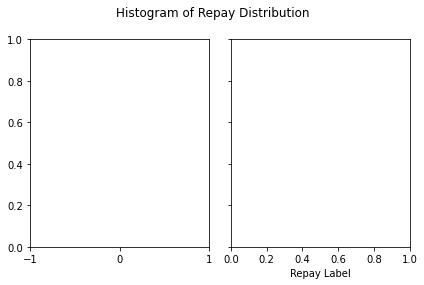

In [34]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Histogram of Repay Distribution')
plt.xlabel('Repay Label')

black_label_dist = data['repay_indices'].loc[data['race']==0]
white_label_dist = data['repay_indices'].loc[data['race']==1]

#print(black_label_dist)
#print(white_label_dist)

# maybe see if the label is an int or a float

# default: 0, repay: 1

n_bins = 4
# We can set the number of bins with the *bins* keyword argument.
#start, end = ax.get_xlim()
stepsize=1
axs[0].xaxis.set_ticks(np.arange(-1, 2, stepsize))
axs[0].set_xticklabels(['','Default','Repay', ''])
axs[0].hist(black_label_dist, bins=n_bins)
axs[0].set_title('Black Group')
axs[0].set_ylabel('No. of Individuals')
axs[0].set_xlabel('Repay Label')

axs[1].xaxis.set_ticks(np.arange(0, 2, stepsize))
axs[1].set_xticklabels(['Default','Repay'])
axs[1].hist(white_label_dist, bins=n_bins)
axs[1].set_title('White Group')

# 3. Classifier

In [ ]:
print('The classifier trained below is: ', model_name)

In [ ]:
if model_name == 'dt':
    # Initialize classifier:
    classifier = DecisionTreeClassifier()
elif model_name == 'gnb':
    classifier = GaussianNB()
elif model_name == 'lgr':
    # Reference: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
    classifier = LogisticRegression()
elif model_name == 'svm_linear':
    # Reference: https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
    classifier = svm.SVC(kernel='linear', probability=True)
elif model_name == 'gbt':
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    # Note: max_depth default is 3 but tune this parameter for best performance
    classifier = GradientBoostingClassifier(n_estimators=100) 
else:
    print('PROBLEM: input a specified classifier above')

## Train classifier and collect predictions
NOTE: atm sample_weight are all 1s

In [ ]:
# Reference: https://www.datacamp.com/community/tutorials/decision-tree-classification-python

# Train the classifier:
model = classifier.fit(X_train,y_train, sample_weight_train)

# Make predictions with the classifier:
y_predict = model.predict(X_test)

# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

### Evaluation of classifier overall

In [ ]:
# Metrics
models_dict = {"Unmitigated": (y_predict, test_scores)}
get_metrics_df(models_dict, y_test, race_test)

In [ ]:
cm = confusion_matrix(y_test, y_predict)
print(cm)
results_dict = classification_report(y_test, y_predict, output_dict=True)
print(classification_report(y_test, y_predict))
# Add accuracy to the results list
unmitigated.append(round(results_dict['accuracy']*100, 2))
f1_micro, f1_weighted, f1_binary = get_f1_scores(y_test, y_predict)
f1_str = str(round(f1_micro*100, 2))+"/"+str(round(f1_weighted*100, 2))+"/"+str(round(f1_binary*100, 2))
# Add f1 scores to results list
unmitigated.append(f1_str)
# Add Selection rate to results list
sr = get_selection_rates(y_test, y_predict, race_test, 0)
unmitigated.append(round(sr*100, 2))
# Add Outcome rates to results list
tnr, tpr, fner, fper = evaluation_outcome_rates(y_test, y_predict, sample_weight_test)
unmitigated.append(round(tnr*100, 2))
unmitigated.append(round(tpr*100, 2))
unmitigated.append(round(fner*100, 2))
unmitigated.append(round(fper*100, 2))

### Delayed impact calculated

In [ ]:
di_black, di_white = calculate_delayed_impact(X_test, y_test, y_predict, race_test)
# Add DI to results list
di_str = str(round(di_black, 2))+"/"+str(round(di_white, 2))
unmitigated.append(di_str)

### Fairness Metric Evaluation of classifier

In [ ]:
dp_diff, eod_diff, eoo_dif, fpr_dif, er_dif = print_fairness_metrics(y_test, y_predict, race_test, sample_weight_test)

# Add the fairness metric differences to results list
unmitigated.append(round(dp_diff*100, 2))
unmitigated.append(round(eod_diff*100, 2))
unmitigated.append(round(eoo_dif*100, 2))
unmitigated.append(round(fpr_dif*100, 2))
unmitigated.append(round(er_dif*100, 2))

### Evaluation of classifier by race

In [ ]:
results_black, results_white = evaluation_by_race(X_test, y_test, race_test, y_predict, sample_weight_test)
unmitigated_black.extend(results_black)
unmitigated_white.extend(results_white)

### Save results to dictionaries

In [ ]:
run_key = 'Unmitigated'
overall_results_dict = add_values_in_dict({}, run_key, unmitigated)
black_results_dict = add_values_in_dict({}, run_key, unmitigated_black)
white_results_dict = add_values_in_dict({}, run_key, unmitigated_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

## Exponentiated Gradient Reduction Alg for Adding Fairness Constraints

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))

### Demographic Parity

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'DP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Save results to dictionaries

In [ ]:
run_key = 'EG DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Equalized Odds

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'EO', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Save results to dictionaries

In [ ]:
run_key = 'EG EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'TPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Save results to dictionaries

In [ ]:
run_key = 'EG EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'FPRP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Save results to dictionaries

In [ ]:
run_key = 'EG FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'ERP', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

### Save results to dictionaries

In [ ]:
run_key = 'EG ERP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Bounded Group Loss (issue, need to figure out loss parameter)

In [ ]:
'''
mitigator, results_overall, results_black, results_white= add_constraint(model, 'BGL', 'EG', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)
run_key = 'EG DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)
'''

## Grid Search Reduction Alg for Adding Fairness Constraints

### Demographic Parity

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'DP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

The next few cells come from: https://github.com/fairlearn/fairlearn/blob/main/notebooks/Binary%20Classification%20with%20the%20UCI%20Credit-card%20Default%20Dataset.ipynb

Note: we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric.

In [ ]:
grid_search_show(mitigator, demographic_parity_difference, y_predict, X_test, y_test, race_test, 'DemParityDifference','GS DPD', models_dict, 0.3)

In [ ]:
models_dict.pop('GS DPD')
models_dict

### Save results to dictionaries

In [ ]:
run_key = 'GS DP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Equalized Odds Used

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'EO', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, equalized_odds_difference, y_predict, X_test, y_test, race_test, 'EOddsDifference','GS EO', models_dict, 0.3)

In [ ]:
models_dict.pop('GS EO')
models_dict

In [ ]:
run_key = 'GS EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### EOO (True Positive Rate Parity)

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'TPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
grid_search_show(mitigator, true_positive_rate_difference, y_predict, X_test, y_test, race_test, 'TPRPDifference','GS TPRP', models_dict, 0.3)

In [ ]:
models_dict.pop('GS TPRP')
models_dict

In [ ]:
run_key = 'GS EOO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### False Positive Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'FPRP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# NOTE: the below models are the same for DT classifier!!

In [ ]:
grid_search_show(mitigator, false_positive_rate_difference, y_predict, X_test, y_test, race_test, 'FPRPDifference','GS FPRP', models_dict, 0.4)

In [ ]:
models_dict.pop('GS FPRP')
models_dict

In [ ]:
run_key = 'GS FPRP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Error Rate Parity

In [ ]:
mitigator, results_overall, results_black, results_white= add_constraint(model, 'ERP', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, True)

In [ ]:
# We can examine the values of lambda_i chosen for us:
lambda_vecs = mitigator.lambda_vecs_
print(lambda_vecs[0])

In [ ]:
# Fairlearn doesnt have an erp difference metric for the below
#grid_search_show(gs_erp, error_difference, y_predict, X_test, y_test, race_test, 'ERDifference','GS ERP', models_dict, 0.3)
#models_dict.pop('GS FPRP')
#models_dict

In [ ]:
run_key = 'GS ERP Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)

### Bounded Group Loss (issue, need to figure out loss parameter)

In [ ]:
'''
mitigator, results_overall, results_black, results_white= add_constraint(model, 'BGL', 'GS', X_train, y_train, race_train, race_test, X_test, y_test, y_predict, sample_weight_test, False)
run_key = 'GS EO Mitigated'
overall_results_dict = add_values_in_dict(overall_results_dict, run_key, results_overall)
black_results_dict = add_values_in_dict(black_results_dict, run_key, results_black)
white_results_dict = add_values_in_dict(white_results_dict, run_key, results_white)
print(overall_results_dict)
print(black_results_dict)
print(white_results_dict)
'''

In [ ]:
# We can examine the values of lambda_i chosen for us:
#lambda_vecs = gs_dp.lambda_vecs_
#print(lambda_vecs[0])

# 4. Save results to csv files

In [ ]:
# To use below!!
overall_fieldnames = ['Run', 'Acc', 'F1micro/F1w/F1bsr', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DIB/DIW', 'DP Diff', 'EO Diff', 'TPR Diff', 'FPR Diff', 'ER Diff']
byrace_fieldnames = ['Run', 'Acc', 'F1micro/F1w/F1bsr', 'SelectionRate', 'TNR rate', 'TPR rate', 'FNER', 'FPER', 'DI']
save_dict_2_csv(overall_results_dict, overall_fieldnames, model_name+'_overall_results.csv')
save_dict_2_csv(black_results_dict, byrace_fieldnames, model_name+'_black_results.csv')
save_dict_2_csv(white_results_dict, byrace_fieldnames, model_name+'_white_results.csv')